# Top overlapping cloud genes by weighted sum for saur cohort

In [1]:
import pandas as pd


pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
pd.set_option("display.expand_frame_repr", False)

## Read token information from bed files

In [2]:
import os
import pandas as pd
from pathlib import Path


bedDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'bed_files', 'ECOLI')

bedDfList = []
for bedFile in os.listdir(bedDir):
    tubeid = bedFile.split('.')[0].split('_')[0]
    tokensDf = pd.read_csv(Path(bedDir, bedFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score'])
    tokensDf['tube_id'] = tubeid
    bedDfList.append(tokensDf)

bedDf = pd.concat(bedDfList, ignore_index=True)
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id
0,1,1,3,GAA,0.024555,AH21B049
1,1,4,12,AAACCCCGG,0.019281,AH21B049
2,1,13,17,TCAAT,0.042749,AH21B049
3,1,18,22,AAGGC,0.058446,AH21B049
4,1,23,27,CGGGG,-0.002272,AH21B049
...,...,...,...,...,...,...
247349726,5,259913,259920,GCTACCCG,0.012245,ALF22C077
247349727,5,259921,259928,TTGGTGTG,0.000125,ALF22C077
247349728,5,259929,259938,CCTGTTCCGT,-0.000540,ALF22C077
247349729,5,259939,259942,GGCC,0.024973,ALF22C077


<Axes: >

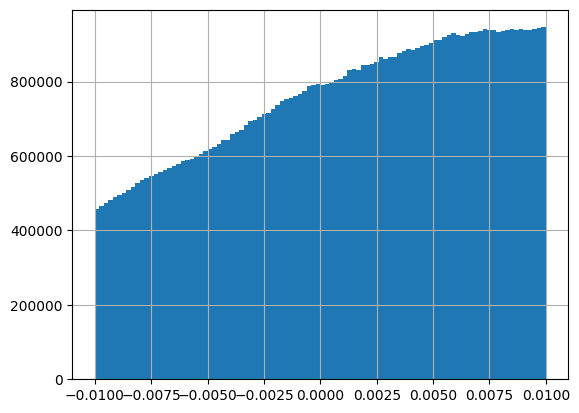

In [3]:
bedDf[(bedDf.score > -0.01) & (bedDf.score < 0.01)].score.hist(bins=100)

In [4]:
bedDf['token_length'] = bedDf.tokens.apply(lambda x: len(x))
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
0,1,1,3,GAA,0.024555,AH21B049,3
1,1,4,12,AAACCCCGG,0.019281,AH21B049,9
2,1,13,17,TCAAT,0.042749,AH21B049,5
3,1,18,22,AAGGC,0.058446,AH21B049,5
4,1,23,27,CGGGG,-0.002272,AH21B049,5
...,...,...,...,...,...,...,...
247349726,5,259913,259920,GCTACCCG,0.012245,ALF22C077,8
247349727,5,259921,259928,TTGGTGTG,0.000125,ALF22C077,8
247349728,5,259929,259938,CCTGTTCCGT,-0.000540,ALF22C077,10
247349729,5,259939,259942,GGCC,0.024973,ALF22C077,4


In [5]:
len(bedDf.tokens.unique())

31990

In [6]:
highscoreCutoff = bedDf.score.mean() + 3 * bedDf.score.std()
highscoreCutoff

np.float64(0.10044996853550375)

In [7]:
highscoreDf = bedDf[bedDf.score > highscoreCutoff]
highscoreDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
790,1,5456,5461,TTCCGG,0.109817,AH21B049,6
1113,1,7709,7713,CCGAC,0.111683,AH21B049,5
1141,1,7901,7906,GGTTTT,0.126671,AH21B049,6
1147,1,7939,7943,GACAG,0.138056,AH21B049,5
1544,1,10694,10701,CCCGACGG,0.119595,AH21B049,8
...,...,...,...,...,...,...,...
247348343,5,250450,250457,CCCTTTTT,0.104689,ALF22C077,8
247348387,5,250737,250741,ACAGA,0.114884,ALF22C077,5
247349058,5,255352,255357,GAAAAA,0.100641,ALF22C077,6
247349081,5,255503,255508,ACGCTG,0.112193,ALF22C077,6


In [8]:
len(highscoreDf.tokens.unique())

13592

In [9]:
highscoreDf.shape

(3266793, 7)

<Axes: >

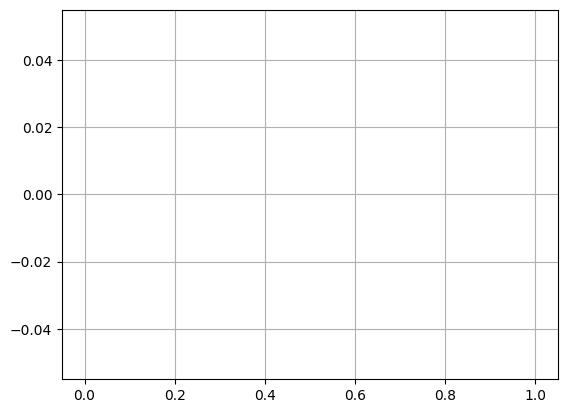

In [10]:
highscoreDf[(highscoreDf.score < 0.05)].score.hist(bins=100)

In [11]:
highscoreDf.token_length.value_counts()

token_length
6     1005832
7      585361
5      449264
8      339503
9      263575
4      262709
3      186469
10      92597
2       40984
11      30865
1        4650
12       2730
16       1991
15        152
13        102
14          9
Name: count, dtype: int64

<Axes: xlabel='token_length', ylabel='Count'>

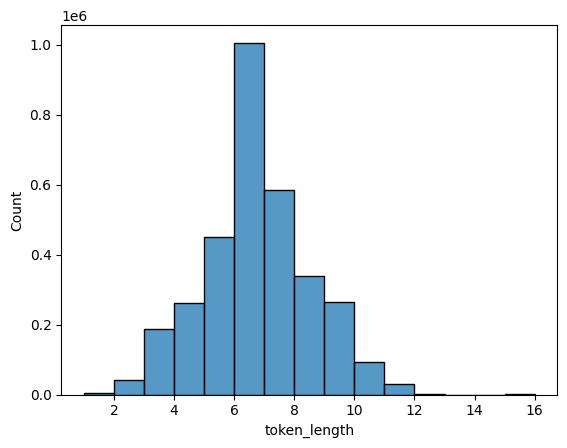

In [12]:
import seaborn as sns

sns.histplot(highscoreDf.token_length, binwidth=1)

## Read cloud genes

In [13]:
import os
from pathlib import Path

import pandas as pd


coreGenesPath = Path(os.environ['GENOMICS_DATA_BASE'], 'annotations', 'e_coli', 'panaroo_strict', 'cloud_genes.csv')
coreGenesDf = pd.read_csv(coreGenesPath)
coreGenesDf['Gene'] = coreGenesDf.Gene.str.lower()
coreGenesDf

,Gene,Occurrences
0,group_15738,129
1,group_7266,129
2,group_6751,129
3,group_2978,129
4,group_2327,129
...,...,...
15628,group_33,1
15629,group_32,1
15630,group_30,1
15631,traj,1


## Read bed files containing overlapping tokens and attribution scores

In [14]:
from tqdm import tqdm

import os
import pandas as pd
from pathlib import Path


annotationOverlappingFilesDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'overlapping_with_annotations', 'ECOLI')

annotationOverlappingDfList = []
for annotationOverlappingFile in tqdm(os.listdir(annotationOverlappingFilesDir)):
    df = pd.read_csv(Path(annotationOverlappingFilesDir, annotationOverlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
    df = df[df.feature_type.isin(['CDS', 'ncRNA', 'oriC', 'regulatory_region', 'oriT'])]
    df['tube_code'] = [annotationOverlappingFile.split('_')[0]]*df.shape[0]
    df = df[df.tokens.apply(lambda x: (len(x) >= 5))].reset_index()
    df['gene'] = df.gene.str.lower()
    coreDf = df[df.gene.isin(coreGenesDf.Gene)]
    annotationOverlappingDfList.append(coreDf)
annotationOverlappingDf = pd.concat(annotationOverlappingDfList, ignore_index=True)
annotationOverlappingDf = annotationOverlappingDf.drop_duplicates()
annotationOverlappingDf


  0%|          | 0/358 [00:00<?, ?it/s]

100%|██████████| 358/358 [04:20<00:00,  1.37it/s]


,index,contig_id,start_position,end_position,tokens,score,feature_type,id,name,gene,atributes,tube_code
0,584,1,5398,5403,GCAGAA,-0.003526,CDS,IGMLFD_00030,porphobilinogen synthase,hemb,"ID=IGMLFD_00030;Name=porphobilinogen synthase;locus_tag=IGMLFD_00030;product=porphobilinogen synthase;Dbxref=COG:COG0113,COG:H,EC:4.2.1.24,GO:0004655,GO:0006782,GO:0046872,KEGG:K01698,RefSeq:WP_001295337.1,SO:0001217,UniParc:UPI000016F200,UniRef:UniRef100_P0ACB2,UniRef:UniRef50_P0ACB2,UniRef:UniRef90_P0ACB2;gene=hemB",AH19C036
1,585,1,5404,5411,TCTTCTTC,-0.031403,CDS,IGMLFD_00030,porphobilinogen synthase,hemb,"ID=IGMLFD_00030;Name=porphobilinogen synthase;locus_tag=IGMLFD_00030;product=porphobilinogen synthase;Dbxref=COG:COG0113,COG:H,EC:4.2.1.24,GO:0004655,GO:0006782,GO:0046872,KEGG:K01698,RefSeq:WP_001295337.1,SO:0001217,UniParc:UPI000016F200,UniRef:UniRef100_P0ACB2,UniRef:UniRef50_P0ACB2,UniRef:UniRef90_P0ACB2;gene=hemB",AH19C036
2,586,1,5412,5416,TCAGC,0.023434,CDS,IGMLFD_00030,porphobilinogen synthase,hemb,"ID=IGMLFD_00030;Name=porphobilinogen synthase;locus_tag=IGMLFD_00030;product=porphobilinogen synthase;Dbxref=COG:COG0113,COG:H,EC:4.2.1.24,GO:0004655,GO:0006782,GO:0046872,KEGG:K01698,RefSeq:WP_001295337.1,SO:0001217,UniParc:UPI000016F200,UniRef:UniRef100_P0ACB2,UniRef:UniRef50_P0ACB2,UniRef:UniRef90_P0ACB2;gene=hemB",AH19C036
3,588,1,5420,5428,ATCCAGCGC,0.015869,CDS,IGMLFD_00030,porphobilinogen synthase,hemb,"ID=IGMLFD_00030;Name=porphobilinogen synthase;locus_tag=IGMLFD_00030;product=porphobilinogen synthase;Dbxref=COG:COG0113,COG:H,EC:4.2.1.24,GO:0004655,GO:0006782,GO:0046872,KEGG:K01698,RefSeq:WP_001295337.1,SO:0001217,UniParc:UPI000016F200,UniRef:UniRef100_P0ACB2,UniRef:UniRef50_P0ACB2,UniRef:UniRef90_P0ACB2;gene=hemB",AH19C036
4,589,1,5429,5434,AAAGTA,0.004816,CDS,IGMLFD_00030,porphobilinogen synthase,hemb,"ID=IGMLFD_00030;Name=porphobilinogen synthase;locus_tag=IGMLFD_00030;product=porphobilinogen synthase;Dbxref=COG:COG0113,COG:H,EC:4.2.1.24,GO:0004655,GO:0006782,GO:0046872,KEGG:K01698,RefSeq:WP_001295337.1,SO:0001217,UniParc:UPI000016F200,UniRef:UniRef100_P0ACB2,UniRef:UniRef50_P0ACB2,UniRef:UniRef90_P0ACB2;gene=hemB",AH19C036
...,...,...,...,...,...,...,...,...,...,...,...,...
4944373,300796,5,349612,349618,TCTGGCT,0.037991,CDS,KCGHAI_11790,Head-tail connector protein FII,fii,"ID=KCGHAI_11790;Name=Head-tail connector protein FII;locus_tag=KCGHAI_11790;product=Head-tail connector protein FII;Dbxref=GO:0019068,GO:0030430,GO:0044423,RefSeq:WP_000752994.1,SO:0001217,UniParc:UPI00018887F4,UniRef:UniRef100_A0A037Y2B4,UniRef:UniRef50_P03714,UniRef:UniRef90_P03714;gene=fII",AH19F069
4944374,300797,5,349619,349629,TGGGCGTGGTG,0.004920,CDS,KCGHAI_11790,Head-tail connector protein FII,fii,"ID=KCGHAI_11790;Name=Head-tail connector protein FII;locus_tag=KCGHAI_11790;product=Head-tail connector protein FII;Dbxref=GO:0019068,GO:0030430,GO:0044423,RefSeq:WP_000752994.1,SO:0001217,UniParc:UPI00018887F4,UniRef:UniRef100_A0A037Y2B4,UniRef:UniRef50_P03714,UniRef:UniRef90_P03714;gene=fII",AH19F069
4944375,300798,5,349630,349637,TACCGCCT,0.028123,CDS,KCGHAI_11790,Head-tail connector protein FII,fii,"ID=KCGHAI_11790;Name=Head-tail connector protein FII;locus_tag=KCGHAI_11790;product=Head-tail connector protein FII;Dbxref=GO:0019068,GO:0030430,GO:0044423,RefSeq:WP_000752994.1,SO:0001217,UniParc:UPI00018887F4,UniRef:UniRef100_A0A037Y2B4,UniRef:UniRef50_P03714,UniRef:UniRef90_P03714;gene=fII",AH19F069
4944376,300799,5,349638,349645,GCCGTTAA,0.039408,CDS,KCGHAI_11790,Head-tail connector protein FII,fii,"ID=KCGHAI_11790;Name=Head-tail connector protein FII;locus_tag=KCGHAI_11790;product=Head-tail connector protein FII;Dbxref=GO:0019068,GO:0030430,GO:0044423,RefSeq:WP_000752994.1,SO:0001217,UniParc:UPI00018887F4,UniRef:UniRef100_A0A037Y2B4,UniRef:UniRef50_P03714,UniRef:UniRef90_P03714;gene=fII",AH19F069


In [15]:
overlappingDf = annotationOverlappingDf[['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'gene', 'name', 'tube_code']].drop_duplicates()
overlappingDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
0,1,5398,5403,GCAGAA,-0.003526,hemb,porphobilinogen synthase,AH19C036
1,1,5404,5411,TCTTCTTC,-0.031403,hemb,porphobilinogen synthase,AH19C036
2,1,5412,5416,TCAGC,0.023434,hemb,porphobilinogen synthase,AH19C036
3,1,5420,5428,ATCCAGCGC,0.015869,hemb,porphobilinogen synthase,AH19C036
4,1,5429,5434,AAAGTA,0.004816,hemb,porphobilinogen synthase,AH19C036
...,...,...,...,...,...,...,...,...
4944373,5,349612,349618,TCTGGCT,0.037991,fii,Head-tail connector protein FII,AH19F069
4944374,5,349619,349629,TGGGCGTGGTG,0.004920,fii,Head-tail connector protein FII,AH19F069
4944375,5,349630,349637,TACCGCCT,0.028123,fii,Head-tail connector protein FII,AH19F069
4944376,5,349638,349645,GCCGTTAA,0.039408,fii,Head-tail connector protein FII,AH19F069


## Get overlapping genes for high-score tokens

In [16]:
highscoreTokenOverlapsDf = overlappingDf.merge(
    highscoreDf[['contig_id', 'start_position', 'end_position', 'tokens']],
    on=['contig_id', 'start_position', 'end_position', 'tokens'],
    how='inner',
)
highscoreTokenOverlapsDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
0,1,5600,5605,CACGAT,0.104541,hemb,porphobilinogen synthase,AH19C036
1,1,5600,5605,CACGAT,0.104541,hemb,porphobilinogen synthase,AH19C036
2,1,5600,5605,CACGAT,0.104541,hemb,porphobilinogen synthase,AH19C036
3,1,5600,5605,CACGAT,0.104541,hemb,porphobilinogen synthase,AH19C036
4,1,5600,5605,CACGAT,0.104541,hemb,porphobilinogen synthase,AH19C036
...,...,...,...,...,...,...,...,...
132519,4,213851,213856,CATAAA,0.119065,tdca,transcriptional regulator TdcA,AH19F069
132520,4,262655,262663,CATCCCCAG,0.115707,yhbx,Putative transferase YhbX,AH19F069
132521,4,262679,262684,ATCCGG,0.138582,yhbx,Putative transferase YhbX,AH19F069
132522,4,305705,305713,GACAGTTTT,0.101715,nana,N-acetylneuraminate lyase,AH19F069


## Calculate weighted sum for all the genes overlapping with high-score tokens

In [17]:
import numpy as np


geneWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['gene']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})
geneWeightedsumDf

/tmp/ipykernel_37574/2423154480.py:4: FutureWarning: The provided callable <function sum at 0x7b734e370280> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  geneWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['gene']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})


,gene,weighted_sum
0,abih,1.590475
1,abiv,1.135510
2,acra,243.982642
3,adhp,3.315191
4,afac,0.240386
...,...,...
568,yrhd,0.149766
569,ytfi,0.341851
570,yurz,2.002300
571,ywqk,4.284197


## Visualise weighted sum

<Axes: xlabel='weighted_sum', ylabel='Count'>

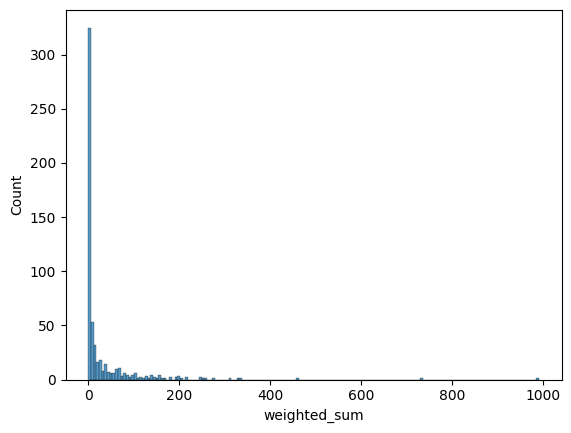

In [18]:
import seaborn as sns


sns.histplot(geneWeightedsumDf.weighted_sum)

## Top genes based on the weighted sum

In [19]:
weightedsumCutoff = geneWeightedsumDf.weighted_sum.mean() + (2 * geneWeightedsumDf.weighted_sum.std())
weightedsumCutoff

np.float64(176.66203093566065)

## Create gene-type lookup table from amrfinderplus annotations

In [20]:
import os

import pandas as pd

from pathlib import Path


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

amrfinderDfList = []
for amrfinderFile in os.listdir(amrfinderDir):
    amrfinderDf = pd.read_csv(Path(amrfinderDir, amrfinderFile), sep='\t')
    amrfinderDfList.append(amrfinderDf)

allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)
allAmrfinderDf

/tmp/ipykernel_37574/536070399.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)


,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description
0,NaN,1,83926,85452,-,aur,zinc metalloproteinase aureolysin,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,509,509,100.00,99.41,509,EHO93748.1,zinc metalloproteinase aureolysin,NaN,NaN
1,NaN,1,128415,129464,+,icaC,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,plus,VIRULENCE,VIRULENCE,NaN,NaN,EXACTX,350,350,100.00,100.00,350,AUU58561.1,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,NaN,NaN
2,NaN,1,150950,154498,-,cna,collagen adhesin Cna,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1183,1183,100.00,98.31,1183,BAB96477.1,collagen adhesin Cna,NaN,NaN
3,NaN,1,277464,278813,+,tet(38),tetracycline efflux MFS transporter Tet(38),core,AMR,AMR,TETRACYCLINE,TETRACYCLINE,EXACTX,450,450,100.00,100.00,450,WP_001100300.1,tetracycline efflux MFS transporter Tet(38),NaN,NaN
4,NaN,1,505300,506652,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.00,99.33,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57610,NaN,17,83399,84580,-,emrD,multidrug efflux MFS transporter EmrD,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,394,394,100.00,99.24,394,ACN65732.1,multidrug efflux MFS transporter EmrD,NaN,NaN
57611,NaN,2,213498,214724,-,kdeA,multidrug efflux MFS transporter KdeA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,409,410,99.76,99.02,409,ABR76310.1,multidrug efflux MFS transporter KdeA,NaN,NaN
57612,NaN,3,59710,60882,+,oqxA,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,BLASTX,391,391,100.00,99.23,391,WP_002914189.1,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,NaN,NaN
57613,NaN,3,60909,64058,+,oqxB9,multidrug efflux RND transporter permease subunit OqxB9,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,ALLELEX,1050,1050,100.00,100.00,1050,WP_012967412.1,multidrug efflux RND transporter permease subunit OqxB9,NaN,NaN


In [21]:
genetypeLookupDf = allAmrfinderDf[['Gene symbol', 'Element type']].drop_duplicates()
genetypeLookupDf['Gene symbol'] = genetypeLookupDf['Gene symbol'].str.lower()
genetypeLookupDf

,Gene symbol,Element type
0,aur,VIRULENCE
1,icac,VIRULENCE
2,cna,VIRULENCE
3,tet(38),AMR
4,mepa,AMR
...,...,...
55837,blapdc-58,AMR
56358,blaact-49,AMR
56951,blandm-4,AMR
56963,aac(6')-ib-cr,AMR


## Read vfdb info

In [22]:
import os
import pandas as pd
from pathlib import Path


vfdbInfoFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'VFDB_info.csv')
vfdbInfoDf = pd.read_csv(vfdbInfoFile)
vfdbInfoDf['Label'] = vfdbInfoDf['Label'].str.lower()
vfdbInfoDf

,Column,ID,Label,Description,Source,Class
0,1,c0393,vat,hemoglobin protease,Escherichia coli O6:K2:H1 CFT073 (UPEC),Autotransporters
1,2,APECO1_O1CoBM73,tsh,Tsh,Escherichia coli O1:K1:H7 (APEC),Autotransporters
2,3,Q673F0_ECOLX,rpea,putative SPATE autotransporter; similar to the SPATE proteins,Escherichia coli plasmid pRAP strain REPEC 83/39,Autotransporters
3,4,ECSF_4010,ecsf_4010,phage protein,Escherichia coli SE15,Autotransporters
4,5,EcSMS35_3921,ecsms35_3921,outer membrane autotransporter,Escherichia coli SMS-3-5 (environmental),Autotransporters
...,...,...,...,...,...,...
249,250,c5077,yddo,ABC transporter ATP-binding protein,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
250,251,c5078,c5078,oligopeptide ABC transporter,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
251,252,c5079,yddq,ABC transporter permease,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
252,253,c5080,yddr,ABC transporter permease,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes


## Read vf collection

In [23]:
import os
import pandas as pd
from pathlib import Path


vfCollectionDescriptionFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'ecoli_VF_collection_description.tsv')
vfCollectionDescriptionDf = pd.read_csv(vfCollectionDescriptionFile, sep='\t')
vfCollectionDescriptionDf['gene'] = vfCollectionDescriptionDf['gene'].str.lower()
vfCollectionDescriptionDf

,gene,locus tag,accession number (protein_id),description,reference,source,class
0,aap,EC042_pAA055,NaN,dispersin,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
1,aata,EC042_pAA008,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
2,aatb,EC042_pAA009,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
3,aatc,EC042_pAA010,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
4,aatd,EC042_pAA011,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
...,...,...,...,...,...,...,...
1064,lngj,NaN,ABU50049,"longus pili, coli surface antigen CS20",Escherichia coli O8:H9 E9034A (ETEC),VFDB R3,Type_4_pilus
1065,lngp,NaN,ABU50050,"longus pili, coli surface antigen CS20",Escherichia coli O8:H9 E9034A (ETEC),VFDB R3,Type_4_pilus
1066,etsa,APECO1_O1CoBM197,YP_001481352,ABC transporter,Escherichia coli O1:K1:H7 APEC O1 plasmid pAPEC-O1-ColBM (APEC),manually,Other_virulence_gene
1067,etsb,APECO1_O1CoBM198,YP_001481353,ABC transporter,Escherichia coli O1:K1:H7 APEC O1 plasmid pAPEC-O1-ColBM (APEC),manually,Other_virulence_gene


## Read ABRicate

In [24]:
import os
import pandas as pd
from pathlib import Path


abricateFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'ABRicate.csv')
abricateDf = pd.read_csv(abricateFile)
abricateDf['gene'] = abricateDf['gene'].str.lower()
abricateDf

,gene,type
0,aaa23990,heat-stable enterotoxin
1,aaa24093,heat labile enterotoxin type IIa A
2,aaa24094,heat labile enterotoxin type IIa B
3,apeco1_1753,hypothetical protein
4,apeco1_1761,hypothetical protein
...,...,...
2696,ygeh,transcriptional regulator
2697,yggr,
2698,yghg,
2699,yijp,


## Add gene descriptions to the top genes

In [25]:
import pandas as pd

pd.set_option('display.max_rows', None)


geneWeightedsumDf[geneWeightedsumDf.weighted_sum > weightedsumCutoff].sort_values(by=['weighted_sum'], ascending=False).merge(
    highscoreTokenOverlapsDf[['gene', 'name']].drop_duplicates(),
    on=['gene'],
    how='inner'
).merge(
    genetypeLookupDf,
    left_on=['gene'],
    right_on=['Gene symbol'],
    how='left'
).rename(
    columns={'Element type': 'AMR Finder Type'}
).merge(
    vfdbInfoDf,
    left_on=['gene'],
    right_on=['Label'],
    how='left'
).rename(
    columns={'Class': 'VFDB Type'}
).merge(
    vfCollectionDescriptionDf,
    on=['gene'],
    how='left'
).rename(
    columns={'class': 'VF Collection Type'}
)[['gene', 'name', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type']].drop_duplicates(subset=['gene', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type'])

,gene,name,weighted_sum,AMR Finder Type,VFDB Type,VF Collection Type
0,yhdj,adenine-specific DNA-methyltransferase,990.997389,NaN,NaN,NaN
2,yhbx,Putative transferase YhbX,733.321465,NaN,NaN,NaN
5,dld,D-lactate dehydrogenase,458.609041,NaN,NaN,NaN
6,glca,glycolate permease GlcA,334.843737,NaN,NaN,NaN
7,dcuc,anaerobic C4-dicarboxylate transporter DcuC,327.761715,NaN,NaN,NaN
8,ybdn,DUF3440 domain-containing protein,313.401107,NaN,NaN,NaN
10,sbcc,exonuclease subunit SbcC,273.102170,NaN,NaN,NaN
11,pote,putrescine-ornithine antiporter,261.052112,NaN,NaN,NaN
13,ldcc,lysine decarboxylase LdcC,250.322536,NaN,NaN,NaN
14,nant,sialic acid transporter NanT,246.581034,NaN,NaN,NaN


## Save all gene hits

In [26]:
import os
import pandas as pd
from pathlib import Path


outputFile = Path(os.environ['GENOMICS_DATA_BASE'], 'temp', 'ecoli_top_cloud_genes_all_overlaping_3sd_tokens.csv')
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False).merge(
    highscoreTokenOverlapsDf[['gene', 'name']].drop_duplicates(),
    on=['gene'],
    how='inner'
).merge(
    genetypeLookupDf,
    left_on=['gene'],
    right_on=['Gene symbol'],
    how='left'
).rename(
    columns={'Element type': 'AMR Finder Type'}
).merge(
    vfdbInfoDf,
    left_on=['gene'],
    right_on=['Label'],
    how='left'
).rename(
    columns={'Class': 'VFDB Type'}
).merge(
    vfCollectionDescriptionDf,
    on=['gene'],
    how='left'
).rename(
    columns={'class': 'VF Collection Type'}
)[['gene', 'name', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type']].drop_duplicates().to_csv(outputFile, index=False)